### Bogdanov-Takens bifurcation
The Andronov-Hopf and saddle-node bifurcation sets can intersect each other, and since the Wilson-Cowan model can have more than one equilibrium, the intersections could correspond to simultaneous bifurcations of different equilibria. 

When both bifurcations happen to be of the same equilibrium the bifurcation is called a Bogdanov- Takens bifurcation, and the Jacobian matrix $J$ verifies,

\begin{equation}
    \text{det} (J) = 0,\quad \text{Tr} (J) = 0 
\end{equation}

this is the condition that we will use to find Bogdanov-Takens bifurcation

### Saddle Node on Invariant Cycle

Let's understand first saddle node on limit cycles. Considering a dynamical system having a saddle-node bifurcation. 

![image](second_task\figures\saddle-node_bifurcation.png)

If the initial condition $x(0)$ starts from the right-hand side of the saddle (open circle), then $x(t)$ increases and leaves a small neighborhood containing the saddle and the node. To study x(t) far away from the neighborhood requires global knowledge of the function f(x, A) . Depending on the function, x(t) can go to infinity or be attracted to another stable equilibrium, limit cycle, chaotic attractor, etc. 

It is also possible that x(t) can return to the neighborhood. The simplest case for this occurs when the left and the right branches of the invariant manifold M make a loop.

![image](second_task\figures\saddle-node_limit_cycle.png)

When x(O) is near the right branch of M, it leaves a neighborhood of the saddle, makes a rotation along M, and approaches the node. Such an excursion in neuroscience applications is called an action potential or a spike. Obviously, the node is an attractor for all x inside the limit cycle and could be an attractor for all points outside the cycle. The activity x(t) of a dynamical system having phase portrait as in Figure 2.29a or b always converges to the node, at least for x(O) close enough to the limit cycle. The invariant manifold M is itself an orbit, which starts from the saddle (open circle in Figure 2.29a) and ends in the node (shaded circle) . Such an orbit is said to be heteroclinic.

### Code

As for the programing we start by defining the same things as the previous task.

In [43]:
import numpy as np
from scipy import optimize
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import tqdm as tqdm
from numba import njit

@njit
def S(x):
    """
    S function
    """
    return np.tanh(x/2)/2
@njit
def S_prime(x):
    return 1/4*(1-np.tanh(x/2)**2)

#Define the System of equations
@njit
def wilson_covan (y, wEE, wEI, wIE, wII, P, t):
    E, I = y
    P_E, P_I = P
    tau_E, tau_I = t
    dEdt = (-E + S (wEE * E - wEI * I + P_E)) / tau_E
    dIdt = (-I + S (wIE * E - wII * I + P_I)) / tau_I
    return np.array([dEdt, dIdt])

def wc_model(t, z, wEE, wIE, wEI, wII):
    x, y = z
    dxdt = -x + np.tanh(wEE * x - wIE * y)
    dydt = -y + np.tanh(wEI * x - wII * y)
    return [dxdt, dydt]

#Define the Jacobian matrix 
@njit
def jacobian(y, wEE, wEI, wIE, wII, P, t):
    E, I = y
    P_E, P_I = P
    tau_E, tau_I = t

    dEdE = (-1 + wEE * S_prime(wEE * E - wEI * I + P_E))/tau_E
    dEdI = -wEI * S_prime(wEE * E - wEI * I +P_E) / tau_E
    dIdE = wIE * S_prime(wIE * E - wII * I + P_I) / tau_I
    dIdI = (-1 - wII*S_prime(wIE * E - wII * I + P_I))/ tau_I

    return np.array([dEdE, dEdI, dIdE, dIdI])

#### Find the fixed points and classify the stability

The same as before the same code is used to find the fixed points.

In [44]:
def fixed_points(wEE, wEI, wIE, wII, tol, initial_guess, P = ([0, 0]), t=[1, 1]):
    fixed_points = [[0, 0]]
    for guess in initial_guess:
        sol = optimize.root(wilson_covan, guess, args=(wEE, wEI, wIE, wII, P, t))
        if sol.success:
            if not any(np.allclose(sol.x, fp, atol=tol) for fp in fixed_points):
                fixed_points.append(sol.x)
    return np.array(fixed_points)

# Stability analysis (Jacobian method)
def stability_analysis(wEE, wIE, wEI, wII, fixed_points, tol_eig=1e-5):
    P=[0, 0]
    T = [1, 1]
    stable = []
    for point in fixed_points:
        J = jacobian(point, wEE, wEI, wIE, wII, P, T)
        J_matrix = np.array([[J[0], J[1]], [J[2], J[3]]])
        eigenvalues = np.linalg.eigvals(J_matrix)
        det = np.linalg.det(J_matrix)
        trace = np.sum(eigenvalues)
        if np.abs(trace) < tol_eig and np.abs(det) < tol_eig and len(fixed_points) == 1:
            return 1 #TB
        else:
            if np.all(np.real(eigenvalues) < 0):
                stable.append("Stable")
            elif np.any(np.real(eigenvalues) > 0):
                stable.append("Unstable")

    if len(fixed_points) == 0 or (len(fixed_points) ==1 and np.count_nonzero(stable == "Unstable") == 1):
        return 3  # oscillatory
    elif len(fixed_points) == 1 and np.count_nonzero(stable == "Stable") == 1:
        return 5 # quiescent
    elif (len(fixed_points) > 2):
        return 2 # bistable
    else:
        # Integrate the system
        sol = solve_ivp(
            wc_model, [0, 200], [0.1, 0.1], args=(wEE, wIE, wEI, wII),
            t_eval=np.linspace(0, 200, 1000), method='RK45', rtol=1e-6, atol=1e-9
        )
        x = sol.y[0]
        t = sol.t
        
        # Find peaks in x(t)
        peaks, _ = find_peaks(x, height=0.1, distance=100)
        if len(peaks) >= 2:
            periods = np.diff(t[peaks])
            avg_period = np.mean(periods)
            frequency = 1 / avg_period
        else:
            frequency = 0
        if frequency == 0 and np.count_nonzero(stable == "Stable") >= 2:
            return 2 # bistable
        elif frequency > 0 and frequency < 0.05:  # ε = small threshold, e.g. 0.05 Hz
            return 4 #SNIC
        elif frequency >= 0.05:
            return 3 # oscillatory
        else:
           return 5 # quiescent


#### Prepare inital values and other parameters.

In [45]:
# Phase diagram
wEI, wII = 10, 1  # Fixed inhibitory parameters
wEE_values = np.linspace(0.1, 30, 50)
wIE_values = np.linspace(0.1, 20, 50)
stability_map = np.zeros((len(wEE_values), len(wIE_values)))

tol_EI = 1e-5 #The toletance in E and I, to consider if 2 close fixed points are the same.

N = 100
x = 2
initial_guesses = np.zeros((N, 2))

for i in range(N):
    initial_guesses[i] = np.array([np.random.uniform(-x, x), np.random.uniform(-x, x)])

for i, wEE in enumerate(wEE_values):
    for j, wIE in enumerate(wIE_values):
        stability_map[i, j] = stability_analysis(wEE, wIE, wEI, wII, fixed_points(wEE, wEI, wIE, wII, tol=tol_EI, initial_guess=initial_guesses))


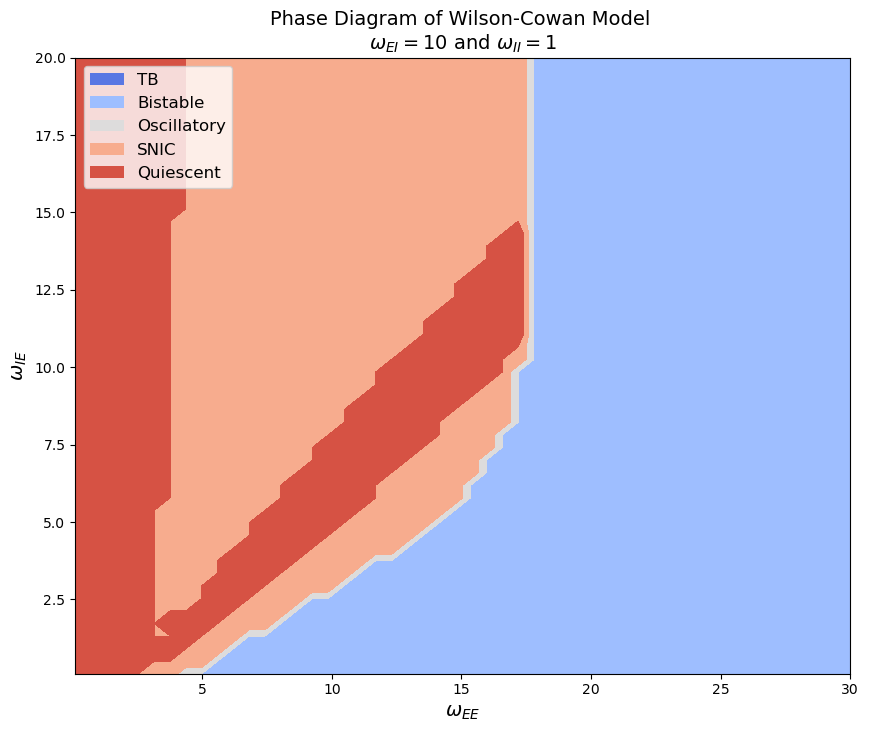

In [46]:
plt.figure(figsize=(10, 8))
cs = plt.contourf(wEE_values, wIE_values, stability_map.T, levels=[0,1,2,3,4,5], cmap='coolwarm')
plt.xlabel(r"$\omega_{EE}$", fontsize = 14)
plt.ylabel(r"$\omega_{IE}$", fontsize = 14)
plt.title("Phase Diagram of Wilson-Cowan Model \n"r"$\omega_{EI} = 10$ and $\omega_{II} = 1$", fontsize = 14)
h1,l1 = cs.legend_elements()
l1 = ['TB', 'Bistable', 'Oscillatory', 'SNIC','Quiescent']
plt.legend(h1, l1, fontsize = 12, loc='upper left')
plt.show()
